In [32]:
#Import necessary packages
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import pandas as pd
import stan
import subprocess
import warnings
warnings.filterwarnings("ignore")

In [33]:
# The Hawkes process kernel used. Weibull Kernel
def kernel(p, t, beta):
    return (1.0-p)**(t**beta)-(1.0-p)**((t+1)**beta)

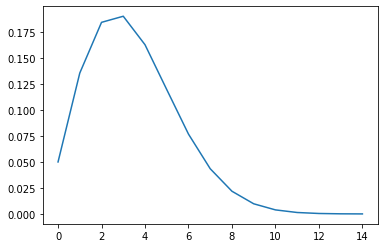

In [3]:
#Plot the Weibull distribution
p = 0.05
beta = 2.0
t = np.zeros(15)
f = np.zeros(15)

for i in range(len(t)):
    f[i] = kernel(p, i, beta)
plt.plot(f)
plt.show()

In [4]:
# Generate Synthetic data from MHP's
M=5
T=300
mu=np.random.rand(M)
mu=mu.reshape((M, 1))

p=0.05
beta=2.0

            
#Set the reproduction matric to have cyclic shape
def create_theta_cycle(d1, d2, M):
    theta=np.zeros([M, M])
    for i in range(M):
        theta[i,i]=d1
        for j in range(M):
            if (np.abs(i-j) % 3) == 1:
                theta[i,j]=d2
    return theta

theta=create_theta_cycle(0.8, 0.05, M)

#SImulate data
def mvh_sim(mu, theta, p, beta, T, M):
    N=np.zeros([M,T])
    lam=np.zeros([M,T])

    for i in range(M):
        lam[i,0]=mu[i]
        N[i,0]=np.random.poisson(lam[i,0])

    for t in range(1,T):
        for i in range(M):
            lam[i,t]=mu[i]
            for j in range(M):
                for s in range(t):
                    lam[i,t]=lam[i,t]+theta[i,j]*kernel(p, t-s-1, beta)*N[j,s]
            N[i,t]=np.random.poisson(lam[i,t])
    return N, lam

N, lam = mvh_sim(mu, theta, p, beta, T, M)

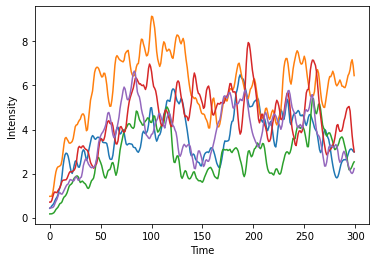

In [5]:
#Plot the simulated intensity
plt.plot(np.transpose(lam))
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.savefig('intensity.eps')
plt.show()

In [6]:
import networkx as nx

#Plotting function for the reproduction matrix graph
def plot_adj_matrix(theta, title, filename = None):
    theta = np.round(theta, decimals=2)
    
    # Shift indices by 1 to start from 1 instead of 0
    theta_shifted = np.pad(theta, ((1, 0), (1, 0)), mode='constant')
    G = nx.from_numpy_array(theta_shifted)
    G.remove_node(0)  # Remove the extra node 0

    self_loops = [(n, n) for n in G.nodes() if G.has_edge(n, n)]
    G.remove_edges_from(self_loops)
    
    
    #G = nx.from_numpy_array(theta)
    pos = nx.circular_layout(G)

    elarge = [(u,v) for (u,v,d) in G.edges(data = True) if d["weight"] > 0.1]
    esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d["weight"] <= 0.1 and d["weight"] > 0.02]

    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width = 6)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width =6 , alpha = 0.5, edge_color='b', style='dashed')

    G1 = G.edge_subgraph(elarge).copy()
    G2 = G.edge_subgraph(esmall).copy()


    nx.draw_networkx_labels(G, pos)
    edge_labels1 = nx.get_edge_attributes(G1, "weight")
    nx.draw_networkx_edge_labels(G1, pos, edge_labels1)
    edge_labels2 = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, edge_labels2)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.title(title, size=20)

    if filename !=None:
        plt.savefig(filename +'.eps')
    else:
        plt.show()
        

In [35]:
Naggr=np.sum(N,axis=0)
print(Naggr)

[ 8.  4.  0.  4.  6.  5. 10.  9.  2.  6.  9.  9.  7.  9. 16. 12.  9. 10.
 15.  4. 14. 14. 11.  7.  7. 11. 10. 12. 12. 12. 11. 11. 12. 12. 10. 15.
 13. 10. 14. 12. 13. 10. 16. 11. 14. 16. 17.  7. 17. 19. 13.  8. 11. 11.
 13. 18. 16. 12. 15. 13. 15. 20. 25. 24. 16. 20. 17. 23. 20. 27. 16. 18.
 22. 21. 23. 21. 30. 20. 24. 21. 26. 25. 22. 36. 20. 19. 27. 22. 24. 15.
 21. 20. 21. 23. 18. 18. 29. 22. 23. 13. 30. 23. 23. 17. 26. 15. 25. 24.
 22. 22. 23. 25. 21. 27. 24. 19. 26. 29. 21. 18. 25. 26. 21. 22. 23. 19.
 24. 20. 27. 28. 24. 21. 34. 26. 29. 19. 31. 25. 21. 30. 20. 39. 25. 33.
 29. 23. 40. 36. 35. 25. 20. 25. 32. 27. 39. 27. 26. 31. 24. 32. 27. 21.
 28. 27. 25. 22. 26. 32. 17. 26. 25. 32. 21. 22. 17. 23. 23. 19. 22. 30.
 18. 25. 17. 17. 22. 21. 27. 19. 15. 24. 17. 22. 23. 27. 28. 32. 24. 29.
 39. 24. 19. 27. 33. 22. 21. 34. 29. 29. 28. 19. 20. 34. 29. 33. 40. 25.
 32. 34. 33. 22. 31. 32. 29. 27. 30. 25. 18. 25. 20. 28. 22. 30. 32. 26.
 25. 28. 24. 35. 29. 32. 34. 33. 30. 28. 22. 34. 31

In [8]:
# Stan to estimate p and beta

model = """
data {
int T; //max number of events
real N[T]; // number of events at each time
}

parameters {
real <lower = 0, upper = 1> p;
real <lower = 0> mu;
real <lower = 0, upper = 1> theta;
real <lower = 0> beta;
}

transformed parameters {

vector[T] lam;

lam[1] = mu;

for (i in 2:T){
lam[i] = mu;
    for (j in 1: (i-1)){
    lam[i] += theta*N[j]*(pow(1-p, pow(i-j-1, beta)) - pow(1-p,pow(i-j, beta)));
    }
    }
}

model {
theta ~ beta(1,1);
p ~ beta(1,1);
mu ~ cauchy(0,5);
beta ~ cauchy(0,5);

for (i in 1:T){
target+= N[i]*log(lam[i]) - lam[i];
}
}
"""

In [12]:
data = {"T":300,"N": Naggr}
posterior = stan.build(model, data=data, random_seed=1)
fit = posterior.sample(num_chains=1, num_samples = 1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_u3t33314/model_vp766d7o.stan', line 4, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1000/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), 

In [13]:
p_est = np.mean(fit['p'])
beta_est = np.mean(fit['beta'])

In [14]:
print('{:.3f}'.format(p_est), ['{:.3f}'.format(np.percentile(fit['p'], 5)), '{:.3f}'.format(np.percentile(fit['p'],95))])
print('{:.3f}'.format(beta_est), ['{:.3f}'.format(np.percentile(fit['beta'], 5)), '{:.3f}'.format(np.percentile(fit['beta'],95))])

0.079 ['0.026', '0.157']
1.807 ['1.316', '2.377']


In [15]:
# Create linear regression from the multivariate Hawkes

def exact_theta(theta, mu):
    M = np.shape(theta)[0]
    theta_vect = np.ones(M*(M+1))
    
    for i in range(M):
        theta_vect[i] = mu[i] #fill the first M elements of the vector 
    cnt = i  #set the cnt value to the last increment of the last loop
    
    for i in range(M):
        for j in range(M):
            cnt+=1
            theta_vect[cnt] = theta[i,j]
    
    return theta_vect

def coef_vec2mat(theta_vect, M):
    theta_est = np.zeros([M,M])
    mu_est = np.zeros(M)
    for i in range(M):
        mu_est[i] = theta_vect[i]
    cnt = i
    for i in range(M):
        for j in range(M):
            cnt+=1
            theta_est[i,j] = theta_vect[cnt]
    return mu_est, theta_est

def create_linear_system(N, p_est, beta_est):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*(M+1)])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                cnt2+=1
                for s in range(t):
                    X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
    return y, X

def create_linear_system_diag(N, p_est, beta_est):
    T = len(N)
    y = np.zeros(T)
    X = np.zeros([T,2])
    for t in range(T):
        y[t] = N[t]
        X[t,0] = 1.0
        for s in range(t):
            X[t,1] += N[s]*kernel(p_est, t-s-1, beta_est)
    return y, X


def create_linear_system_offdiag(N, p_est, beta_est, theta_diag):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*(M+1)])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                if i!=j:
                    cnt2+=1
                    for s in range(t):
                        X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
                else:
                    for s in range(t):
                        X[cnt,(M*M)] += N[j,s]*kernel(p_est, t-s-1, beta_est)*theta_diag[i]
    return y, X

def create_linear_system_fixdiag(N, p_est, beta_est, theta_diag):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*M])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                if i!=j:
                    cnt2+=1
                    for s in range(t):
                        X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
                else:
                    for s in range(t):
                        y[cnt] -= N[j,s]*kernel(p_est, t-s-1, beta_est)*theta_diag[i]
    return y, X

In [16]:
# Linear estimate method
def full_linear_estimate(N, p_est, beta_est, x, M):
    T = N.shape[1]
    N_train = (T//10)*x
    y, X = create_linear_system(N, p_est, beta_est)
    reg = LinearRegression(positive=True, fit_intercept=False).fit(X[0:N_train,:], y[0:N_train])
    mu_est, theta_est = coef_vec2mat(reg.coef_, M)
    
    yhat = np.matmul(X,reg.coef_)
    mse = np.mean((y[N_train:]-yhat[N_train:])**2) #mean squared error
    
    return mu_est, theta_est, mse

In [17]:
# Ridge estimate method (Ridge for diag_param = 1 and Ridge Diag for diag_param = 0)
def ridge_estimate(N, p_est, beta_est, x, diag_param, M, Nsamp):
    T = N.shape[1]
    N_train = (T//10)*x 
    y,X = create_linear_system(N, p_est, beta_est)
    pfac = np.ones(X.shape[1])
    if diag_param == 1:
        cnt = -1
        cnt2 = M-1
        for i in range(M):
            pfac[i]=0.0
            cnt+=1
            for j in range(M):
                cnt2+=1
                if i==j:
                    pfac[cnt2]=0.0
    pd.DataFrame([Nsamp]).to_csv('Nsamp.csv',index=False,header=False)
    pd.DataFrame(X).to_csv('X.csv',index=False,header=False)
    pd.DataFrame(y).to_csv('y.csv',index=False,header=False)
    pd.DataFrame(pfac).to_csv('pfac.csv',index=False,header=False)
   

    subprocess.call("Rscript mvhawkes_glmnet.R", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    ridge_coef=pd.read_csv("glm_coefs.csv")
    
    mu_est, theta_est = coef_vec2mat(ridge_coef['x'], M)

    yhat = np.matmul(X, ridge_coef['x'])

    mse = np.mean((y[N_train:]-yhat[N_train:])**2)

    return mu_est, theta_est, mse


In [18]:
#Elastic Net Estimate (Elastic Net for diag_param = 1 and Elastic Net Diag for diag_param = 0)
def ridge_estimate_lasso(N, p_est, beta_est, x, diag_param, M, Nsamp):
    T = N.shape[1]
    N_train = (T//10)*x
    y,X = create_linear_system(N, p_est, beta_est)
    pfac = np.ones(X.shape[1])
    if diag_param == 1:
        cnt = -1
        cnt2 = M-1
        for i in range(M):
            pfac[i]=0.0
            cnt+=1
            for j in range(M):
                cnt2+=1
                if i==j:
                    pfac[cnt2]=0.0
    pd.DataFrame([Nsamp]).to_csv('Nsamp.csv',index=False,header=False)
    pd.DataFrame(X).to_csv('X.csv',index=False,header=False)
    pd.DataFrame(y).to_csv('y.csv',index=False,header=False)
    pd.DataFrame(pfac).to_csv('pfac.csv',index=False,header=False)
   

    subprocess.call("Rscript mvhawkes_glmnet_lasso.R", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    ridge_coef=pd.read_csv("glm_coefs.csv")
    
    mu_est, theta_est = coef_vec2mat(ridge_coef['x'], M)

    yhat = np.matmul(X, ridge_coef['x'])

    mse = np.mean((y[N_train:]-yhat[N_train:])**2)

    return mu_est, theta_est, mse

In [19]:
#Staged1
def staged_estimate(N, p_est, beta_est, x, M):
    T = N.shape[1]
    N_train = x*(T//10)
    mu_diag=np.zeros(M)
    theta_diag=np.zeros(M)
    for i in range(M):
        y1,X1=create_linear_system_diag(N[i,:],p_est,beta_est)
        reg1 = LinearRegression(positive=True,fit_intercept=False).fit(X1[0:N_train,:], y1[0:N_train])
        
        mu_diag[i]=reg1.coef_[0]
        theta_diag[i]=reg1.coef_[1]
        
        
    yoff, Xoff = create_linear_system_offdiag(N,p_est,beta_est,theta_diag)
    regoff = LinearRegression(positive=True,fit_intercept=False).fit(Xoff[0:N_train,:], yoff[0:N_train])
    y_hatoff=np.matmul(Xoff,regoff.coef_)
    
    theta_est=np.zeros([M,M])
    mu_est=np.zeros(M)

    rho=regoff.coef_[-1]
    #print(rho)
    for i in range(M):
        mu_est[i]=regoff.coef_[i]
        theta_est[i,i]=rho*theta_diag[i]

    cnt2=i
    for i in range(M):
        for j in range(M):
            if i!=j:
                cnt2+=1
                theta_est[i,j]=regoff.coef_[cnt2]
            
            
    
    mse=np.mean((yoff[N_train:]-y_hatoff[N_train:])**2)
    
    return mu_est,theta_est,mse

In [20]:
#Staged2
def staged_fixed_estimate(N, p_est, beta_est, x, M):

    T = N.shape[1]
    N_train = (T//10)*x
    
    mu_diag = np.zeros(M)
    theta_diag = np.zeros(M)

    ybase = np.zeros(M*T)
    for i in range(M):
        y1, X1 = create_linear_system_diag(N[i,:], p_est, beta_est)
        reg1 = LinearRegression(positive=True, fit_intercept=False).fit(X1[0:N_train:],y1[0:N_train])

        mu_diag[i] = reg1.coef_[0]
        theta_diag[i] = reg1.coef_[1]
        
    yoff, Xoff = create_linear_system_fixdiag(N, p_est, beta_est, theta_diag)
    regoff = LinearRegression(positive=True, fit_intercept=False).fit(Xoff[0:N_train:],yoff[0:N_train])
    yhatoff = np.matmul(Xoff, regoff.coef_)

    theta_est = np.zeros([M,M])
    mu_est = np.zeros(M)

    for i in range(M):
        mu_est[i] = regoff.coef_[i]
        theta_est[i,i] = theta_diag[i]
    cnt2 = i
    for i in range(M):
        for j in range(M):
            if i!=j:
                cnt2+=1
                theta_est[i,j] = regoff.coef_[cnt2]

    mse = np.mean((yoff[N_train:]-yhatoff[N_train:])**2)

    return mu_est, theta_est, mse
                

In [21]:
#Run the cycle experiment with the different estimation methods over 1000 simulation
Dfull = []
Drid  = []
Drid_lasso = []
Drid_lasso_diag = []
Dridiag = []
Dstage = []
Dfix = []

Ofull = []
Orid  = []
Orid_lasso = []
Orid_lasso_diag = []
Oridiag = []
Ostage = []
Ofix = []


mfull = []
mrid  = []
mrid_lasso = []
mrid_lasso_diag = []
mridiag = []
mstage = []
mfix = []

M = 5
Nsamp = 300
#scaling_factor = 1000.0
number_of_simulations = 1000
x  = 7

for k in range(number_of_simulations):
    N, lam = mvh_sim(mu, theta, p, beta, T, M)
    mu_full, theta_full, mse_full = full_linear_estimate(N, p_est, beta_est, x, M)
    mu_ridge_diag, theta_ridge_diag, mse_ridge_diag = ridge_estimate(N, p_est, beta_est, x, 1, M, Nsamp)
    mu_ridge, theta_ridge, mse_ridge = ridge_estimate(N,p_est, beta_est, x, 0, M, Nsamp)
    mu_ridge_lasso_diag, theta_ridge_lasso_diag, mse_ridge_lasso_diag = ridge_estimate_lasso(N, p_est, beta_est, x, 0, M, Nsamp)
    mu_ridge_lasso, theta_ridge_lasso, mse_ridge_lasso = ridge_estimate_lasso(N, p_est, beta_est, x, 1, M, Nsamp)
    mu_stage_fix, theta_stage_fix, mse_stage_fix = staged_fixed_estimate(N, p_est, beta_est, x, M)
    mu_stage, theta_stage, mse_stage = staged_estimate(N, p_est, beta_est, x, M)

    mfull.append(mse_full)
    mrid.append(mse_ridge)
    mridiag.append(mse_ridge_diag)
    mrid_lasso.append(mse_ridge_lasso)
    mrid_lasso_diag.append(mse_ridge_lasso_diag)
    mstage.append(mse_stage)
    mfix.append(mse_stage_fix)


    if k==0:
        theta1 = theta_full/number_of_simulations
        theta2 = theta_ridge/number_of_simulations
        theta3 = theta_ridge_lasso/number_of_simulations
        theta4 = theta_ridge_lasso_diag/number_of_simulations
        theta5 = theta_ridge_diag/number_of_simulations
        theta6 = theta_stage/number_of_simulations
        theta7 = theta_stage_fix/number_of_simulations
    else:
        theta1 += theta_full/number_of_simulations
        theta2 += theta_ridge/number_of_simulations
        theta3 += theta_ridge_lasso/number_of_simulations
        theta4 += theta_ridge_lasso_diag/number_of_simulations
        theta5 += theta_ridge_diag/number_of_simulations
        theta6 += theta_stage/number_of_simulations
        theta7 += theta_stage_fix/number_of_simulations
        
    for i in range(M):
        Dfull.append(theta_full[i,i])
        Drid.append(theta_ridge[i,i])
        Drid_lasso.append(theta_ridge_lasso[i,i])
        Drid_lasso_diag.append(theta_ridge_lasso_diag[i,i])
        Dridiag.append(theta_ridge_diag[i,i])
        Dstage.append(theta_stage[i,i])
        Dfix.append(theta_stage_fix[i,i])
        #Dind.append(theta_indep[i])
        for j in range(M):
            if i!=j:
                Ofull.append(theta_full[i,j])
                Orid.append(theta_ridge[i,j])
                Orid_lasso.append(theta_ridge_lasso[i,j])
                Orid_lasso_diag.append(theta_ridge_lasso_diag[i,j])
                Oridiag.append(theta_ridge_diag[i,j])
                Ostage.append(theta_stage[i,j])
                Ofix.append(theta_stage_fix[i,j])
    
    print(k, np.mean(mfull), np.mean(mrid), np.mean(mridiag), np.mean(mrid_lasso), np.mean(mrid_lasso_diag), np.mean(mstage), np.mean(mfix))
    print(k, np.mean(Dfull), np.mean(Drid), np.mean(Dridiag),  np.mean(Drid_lasso), np.mean(Drid_lasso_diag), np.mean(Dstage), np.mean(Dfix))
    print(k, np.mean(Ofull), np.mean(Orid), np.mean(Oridiag), np.mean(Orid_lasso),  np.mean(Orid_lasso_diag), np.mean(Ostage), np.mean(Ofix))
    print('')

0 30.263430718272332 6.321301304421345 6.155739400206849 6.132087562901701 6.130250327329455 35.56373102911302 9.539809028870236
0 0.20978452355375438 0.48678953262703517 0.7916795704004815 0.7383496277800853 0.7125161859873665 0.0 0.8485165351120136
0 0.260069745497444 0.09603671990163504 0.019121442437905596 0.0363420733792092 0.043674208053229 0.287602636742207 0.0749677954523051

1 18.50555101627327 5.446918577274614 5.333873139132017 5.318576869376756 5.317143876513662 20.87620545243579 7.228910868735774
1 0.20028330666880398 0.4949431397301306 0.7717006402657577 0.7313923439779785 0.697709949639232 0.0 0.8151032685531281
1 0.24009946484968886 0.09525865080639134 0.02753730048583646 0.04027625371082575 0.05091414092662294 0.25053969816430843 0.06334441725735826

2 17.059697174421988 5.5308622609853195 5.4244127785023055 5.405223456891661 5.4054875150186215 19.00319636979643 6.859034731419616
2 0.16229883650222085 0.4817260924701311 0.7469084010929822 0.6890055867036072 0.657532675

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


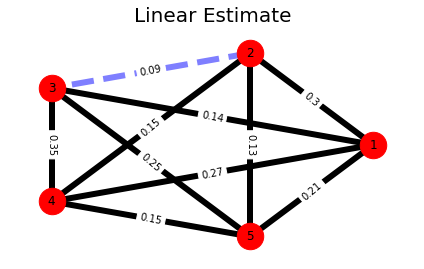

In [22]:
plot_adj_matrix(theta1, 'Linear Estimate', 'Linear_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


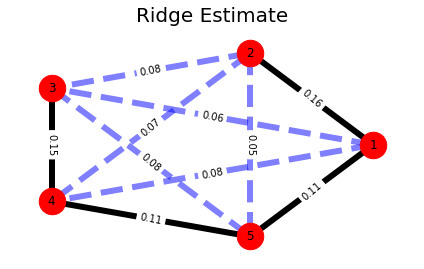

In [23]:
plot_adj_matrix(theta2, 'Ridge Estimate', 'Ridge_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


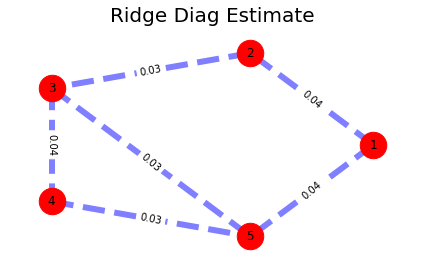

In [24]:
plot_adj_matrix(theta5, 'Ridge Diag Estimate', 'Ridge_Diagonal_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


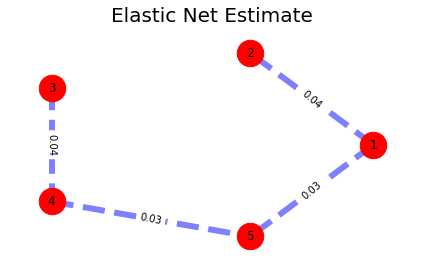

In [25]:
plot_adj_matrix(theta3, 'Elastic Net Estimate', 'Elastic_Net_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


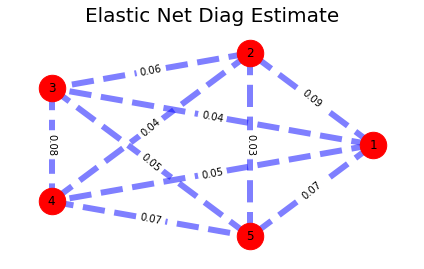

In [26]:
plot_adj_matrix(theta4, 'Elastic Net Diag Estimate', 'Elastic_Net_Diagonal_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


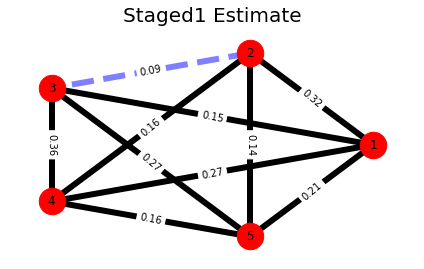

In [27]:
plot_adj_matrix(theta6, 'Staged1 Estimate', 'Staged1_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


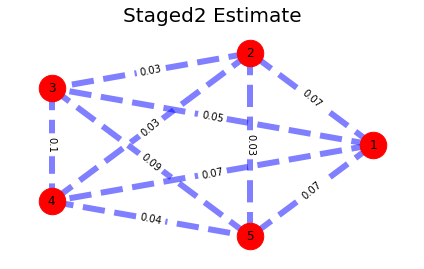

In [28]:
plot_adj_matrix(theta7, 'Staged2 Estimate', 'Staged2_Estimate')

In [36]:
#Table of the results
cycle_table = {' ': ['Linear', 'Ridge', 'Ridge Diag', 'Elastic Net', 'Elastic Net Diag', 'Staged1', 'Staged2'],
               'Mean Squared Error': ['{:.3f}'.format(np.mean(mfull)), '{:.3f}'.format(np.mean(mrid)), '{:.3f}'.format(np.mean(mridiag)),
                                      '{:.3f}'.format(np.mean(mrid_lasso)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_diag)), '{:.3f}'.format(np.mean(mstage)), 
                                      '{:.3f}'.format(np.mean(mfix))],
              'R Diagonal': ['{:.3f}'.format(np.mean(Dfull)), '{:.3f}'.format(np.mean(Drid)), '{:.3f}'.format(np.mean(Dridiag)),
                             '{:.3f}'.format(np.mean(Drid_lasso)),
                                      '{:.3f}'.format(np.mean(Drid_lasso_diag)), '{:.3f}'.format(np.mean(Dstage)), 
                             '{:.3f}'.format(np.mean(Dfix))],
              'R Off diagonal': ['{:.3f}'.format(np.mean(Ofull)), '{:.3f}'.format(np.mean(Orid)), '{:.3f}'.format(np.mean(Oridiag)), 
                                 '{:.3f}'.format(np.mean(Orid_lasso)),
                                      '{:.3f}'.format(np.mean(Orid_lasso_diag)), '{:.3f}'.format(np.mean(Ostage)), 
                                 '{:.3f}'.format(np.mean(Ofix))]}


In [30]:
pd.DataFrame(cycle_table)

,,Mean Squared Error,R Diagonal,R Off diagonal
0,Linear,13.405,0.147,0.218
1,Ridge,5.095,0.487,0.097
2,Ridge Diag,5.006,0.745,0.028
3,Elastic Net,5.009,0.748,0.025
4,Elastic Net Diag,4.984,0.663,0.058
5,Staged1,13.946,0.000,0.229
6,Staged2,6.589,0.806,0.063


In [96]:
import pandas as pd
table = pd.DataFrame(cycle_table)
table.to_csv('Cycle_simulation_results', index = None)

In [50]:
#pd.read_csv('Cycle_simulation_results')

### Multicollinearity analysis

In [40]:
#Create a reproduction matrix
def theta_creation(d1, M):
    theta=d1 * np.ones([M,M])
    for i in range(M):
        for j in range(M):
            if i != j:
                theta[i,j]=.045*d1
    return theta

In [41]:
offdiag = np.sort(np.random.uniform(0, 1, 100))

In [42]:
theta_list = []
max_eigenvalues_list = []
#List of 100 reproduction matrices
for j in offdiag:
    theta = theta_creation(j, 5)
    theta_list.append(theta)
#Compute the maximum eigenvalues for each matrix and store in the list max_eigenvalues_list
for i in range(len(theta_list)):
    max_eigenvalues_list.append(max(np.linalg.eigvals(theta_list[i])))
max_eigenvalues_list = np.sort(np.real(max_eigenvalues_list))

In [43]:
N_list = []
X_list = []
#Generate the synthetic data dor each matrix and compute the predictor using the linear system created above
for i in range(len(theta_list)):
    N_list.append(mvh_sim(mu, theta_list[i], 0.05, 2.0, T, M)[0])
    X_list.append(create_linear_system(N_list[i], 0.05, 2.0)[1])

In [44]:
from scipy.stats import spearmanr

In [45]:
corr_list = []
max_correlation_list = []
#Compute the maximum correlation for each predictor
for i in range(len(theta_list)):
    corr_list.append(spearmanr(X_list[i]).correlation)
    corr_list[i] = (corr_list[i] + corr_list[i].T)/2
    for k in range(corr_list[i].shape[0]):
        for l in range(corr_list[i].shape[1]):
            if k==l:
                corr_list[i][k,l] = 0
    max_correlation_list.append(np.max(corr_list[i]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


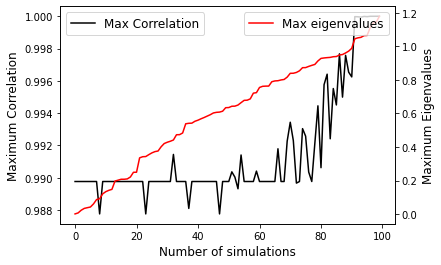

In [49]:
#Plot the maximum correlation and the maximum eigenvalues 
fig, ax=plt.subplots() 
ax2=ax.twinx()

ax.plot(max_correlation_list, 'black', label = 'Max Correlation')
ax2.plot(max_eigenvalues_list, 'r', label = 'Max eigenvalues')
ax.legend(loc='upper left', fontsize = 12)
ax2.legend(loc='upper right', fontsize = 12)
ax.set_xlabel('Number of simulations', fontsize = 12)
ax.set_ylabel('Maximum Correlation', fontsize = 12)
ax2.set_ylabel('Maximum Eigenvalues', fontsize = 12)
plt.savefig('corr_and_eigen.eps')
plt.show()

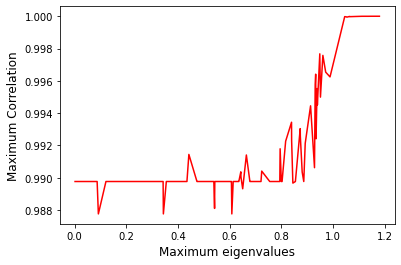

In [47]:
#Plot the mac correlations versus the max eigenvalues
plt.plot(max_eigenvalues_list, max_correlation_list, color = 'r')
plt.xlabel('Maximum eigenvalues', fontsize = 12)
plt.ylabel('Maximum Correlation', fontsize = 12)
plt.savefig('corr_vs_eigen.eps')
plt.show()

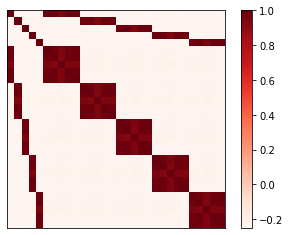

In [48]:
#See the correlation of one of the reproduction matrices (the first in the list) in an map image style
corr_list[0]
np.fill_diagonal(corr_list[0], 1)
#corr_list[0]
plt.imshow(corr_list[0],cmap='Reds')

plt.colorbar()
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig('multicollinearity_map.eps') 